# Introduction

Customers does not only look for online shopping with the best variety of products and best user experience. They are also demanding fast delivery without delays. Throughout the project we have analyzed various hypotheses that might help Olist optimize business critical KPI's that focus on the cutomer, the sellers, and the process of purchasing products, keeping customers, getting the best sellers on the platform, etc. In this last part, we will analyze the potential of maximizing the latent but critical value in the process of delivering the products. Estimation of delivery is both important when the customer is choosing between products and potentially holding delivery date as a decisive factor, and when delivering the physical product to the customer by connecting logistics providers and various sellers. These operational tasks, which is not directly handled by Olist, are critical to Olist's image and how satisfied customers are after shopping on Olist. 

The goal with the following analysis is threefold. First, we are assessing whether there exist a problem in terms of delivering the products to the customers. The delivery performance is analyzed by looking at historical data and how many delays Olist has had thoughout the dataset. Second, we will optimize Olist's estimate of delivery resulting in better decision-making for the customers and higher convenience throughout the later part of the shopping experience. Lastly, we are going to predict whether an order will be delivered in time or too late by classifying an order upon purchase. 

## KPI's

Operational excellence is at the hart of an Ecommerce if customer satisfaction is a top priority. Optimization across both estimated delivery and potential delivery delay is helping Olist on several important KPI's. We can potentially increase Customer Acquisition and Customer Retention rates if Olist are able to proof a trackrecord of fast and exact delivery. Furthermore, if we are able to predict whether a package is late or not and use a set of tools to counteract a potential late delivery, the number of Late Deliveries is a KPI in itself that we would want to optimize. 

# <font color='blue'>Setup 1</font>: Load Libraries

In [48]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%matplotlib inline
sns.set()
sns.color_palette("Paired")
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data

The workbook will focus on the delivery and Geospatial part of the OLIST dataset. Therefore, the following datasets are loaded and joined:

- olist_customers_dataset
- olist_order_items_dataset
- olist_customers_dataset
- olist_sellers_dataset
- olist_geolocation_dataset

These are joined by the left-join operation and dataformat is set. 

In [2]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [3]:
# Reading the olist_orders table
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers = load_table('olist_sellers_dataset.csv')
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']
geo = load_table('olist_geolocation_dataset.csv')

### Jensen kan måske forklare dette

In [4]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

/Users/MartinJohnsen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [5]:
# Removing outliers based on coordinates
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]
#source: https://www.kaggle.com/andresionek/geospatial-analysis-of-brazilian-e-commerce

## 1. Merge datasets

First, we are taking a look at the geolocations 

In [6]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


Since the zip-codes has several different geolocations very close to each other, we will aggregate those different locations into a mean location. Even though it is not geographically correct to take the mean of the longitude and latitude, especially is the distances are large, we assume that it is coorect in this example. Argualy, it does not make a difference in this example since the distances are very close. 

In [7]:
geo = geo.groupby('geolocation_zip_code_prefix')['geolocation_lat','geolocation_lng'].agg('mean').reset_index()

Now that each zipcode has a unique geolocations, they are joined (left) on the customer and sellers dataset

In [8]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']

Each sellers geo location is then joined with the orders dataset.

In [10]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 'order_purchase_timestamp',
                         'order_approved_at','order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date','order_price',
                         'quantity','freight_value','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In this analysis only the orders with an order status of "delivered" are considered. As seen from the list below several different order statuses exist. 

In [11]:
print(list(set(orders_all.order_status)))
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

['unavailable', 'processing', 'delivered', 'approved', 'canceled', 'invoiced', 'shipped', 'created']


All the timestamp columns are changed to pandas datetime format

In [12]:
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

First the number of missing values (NaN) are counted for each column and then they are removed

In [13]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    print(num_missing)
          
count_missing_values(delivered_orders)
delivered_orders = delivered_orders.dropna()

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  14      0.0001
order_delivered_carrier_date        2      0.0000
shipping_limit_date                 0      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_price                         0      0.0000
quantity                            0      0.0000
freight_value                       0      0.0000
customer_lat                      274      0.0027
customer_lon                      274      0.0027
seller_lat                        222      0.0022
seller_lon                        222      0.0022


## 2. Descriptive analysis

When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. A customer is given an `order_estimated_delivery_date`.

In the following we are trying to assess how many order are delivered later than estimated and why this might happen. We are considering purchase date, shipping limit date, order estimated delivery data and actual delivery date as relevant columns in regards to analyzing delivery times. 

In [14]:
#Calculating difference between order_estimated_delivery_date and the actual order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

In [15]:
delivered_orders['delivery_difference'].describe()

count    99678.000000
mean        10.987720
std         10.208975
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64

The customer recieves the product 10,98 days ahead of the estimated delivery day on average.

In [16]:
print("Number of orders delivered later than the estimated delivery data:",len(delivered_orders[delivered_orders['delivery_difference']<0]))

Number of orders delivered later than the estimated delivery data: 7943


Meaning ~8% of the orders was delivered later than the estimated delivery date.

In the olist_orders_dataset we have 95,978 unique orders and 99,678 total orders, i.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether we are to blame the sellers or the logistic firm for the orders delivered late. Therefore, we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If X > 0 the order was delivered on time. 
- If X < 0 and Y > 0 the logistic firm is the one to blame
- If X < 0 and Y >= X then the seller is the one to blame
- If X < 0 and Y < 0 the both the seller and the logistic firm is to blame

Before plotting the delivery times, we need to calculate the difference between the `shipping_limit_date` and `order_delivered_carrier_date`. 

In [17]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

In [18]:
# Removing outlier
delivered_orders = delivered_orders.drop(89664)
delivered_orders['shipping_difference'].describe()

count    99677.000000
mean         2.832569
std          3.747486
min       -117.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        175.000000
Name: shipping_difference, dtype: float64

As seen in the above table, a product is passed on to the logistic firm 2.8 days ahead on average, which indicates that sellers are proably not the error. However, we will se that below. 

In [19]:
def plot_late_order(df):
    X = [x for x in df.delivery_difference]
    X = np.array(X)
    Y = [y for y in df.shipping_difference]
    Y = np.array(Y)

    col = np.where((X<0) & (Y<0) & (Y<X),'red',
            np.where((X<0) & (Y<0) & (Y>=X),'yellow',
                np.where((X<0) & (Y>=0),'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Delivery difference')
    ax.set_ylabel('Shipping difference')
    ax.set_title('Orders')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

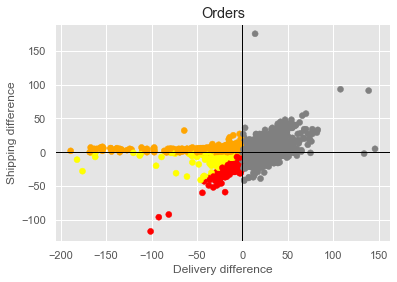

In [20]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

Counting the number of points in each category to find the distribution of the different causes of delay. 

In [21]:
X = [x for x in delivered_orders.delivery_difference]
Y = [y for y in delivered_orders.shipping_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]>=0)]
yellow_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]>=X[i])]
red_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]<X[i])]

In [22]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 92.03 pct. of the orders was delivered on time
  5.78 pct. of the orders was delivered late because of the logistic firm
  1.34 pct. of the orders was delivered late because of the seller
  0.85 pct. of the orders was delivered late because of both the seller and logistic firm


The data clearly suggests that the main problem with the late orders is the logistic provider not providing the service needed to deliver on time. This might already suggest improvements, such as better logisitcs deals and potentially contractual agreements about a minimum threshold for late deliveries. 

## 3. Estimated delivery time

In order to improve the estimated delivery time, we are investigating whether there exist an actual problem with the current estimate that Olist are providing the customer at the purchase moment. Before looking into the problem, we are creating some features necessary for the analysis. 

### 3.1 Creating features

We can create some features relevant for the problem such as:
- actual delivery date
- distance from seller to customer

Apart from that, we have features from the original datasets provided by Olist.

In [23]:
#Calculating the actual delivery time
delivered_orders['actual'] = delivered_orders.order_delivered_customer_date - delivered_orders.order_purchase_timestamp
delivered_orders['actual'] = delivered_orders['actual'].dt.days

In [24]:
#Displaying information about the actual delivery times on the products
delivered_orders.actual.describe()

count    99677.000000
mean        12.021128
std          9.530163
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: actual, dtype: float64

In [26]:
#Creating a function for calculating distances from seller to customer. 
def geoDistance(lat0, lon0, lat1, lon1):
    # Approx. radius of earth (km)
    R = 6373.0 
    # Convert to radians
    lat0, lon0 = radians(lat0), radians(lon0)
    lat1, lon1 = radians(lat1), radians(lon1)
    
    # Getting differences
    dlon, dlat = lon1 - lon0, lat1 - lat0
    
    # Use haversine formula
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [27]:
#Calling the function to create a distance measure for all orders
delivered_orders['Distance'] = delivered_orders.apply(lambda row:\
    geoDistance(row['customer_lat'], row['customer_lon'], row['seller_lat'], row['seller_lon']), axis=1)

In [28]:
#Calculating the estimated delivery in days
delivered_orders["estimated_delivery"] = (delivered_orders.order_estimated_delivery_date-delivered_orders.\
                                          order_purchase_timestamp).dt.total_seconds() / (24 * 60 * 60)

In [29]:
#Defining the relevant features for the problem
features = ['order_price','quantity','freight_value','customer_lat',
           'customer_lon','seller_lat','seller_lon','Distance','estimated_delivery']
target = ['actual']

X = np.array(delivered_orders[features])
y = np.array(delivered_orders['actual'])
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

The distribution of the `actual delivery` feature created can be plotted with the distribution of the `estimated delivery` feature to get an idea about Olist's estimated deliveries versus their actual deliveries. 

In [30]:
#Creating variables for both actual and estimated deliveries
actual_delivery = delivered_orders.actual
estimated_delivery = delivered_orders.estimated_delivery

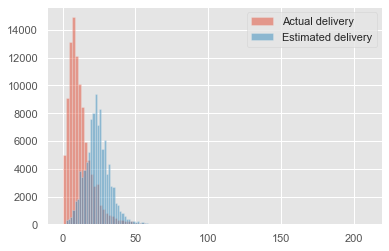

In [31]:
#Plotting actual delivery times and estimated delivery times
plt.hist(actual_delivery, bins= 100, alpha=0.5, label='Actual delivery')
plt.hist(estimated_delivery, bins= 100, alpha=0.5, label='Estimated delivery')
plt.legend(loc='upper right')
plt.show()

As can be seen from the plot above, Olist are systematically overestimating the delivery dates, which might give customers a motivation for shopping through another eCommerce, if they are estimating a faster delivery. 
Therefore, we want to enable a correct and much better estimated delivery time, so that the customer gets more correct information about the faster delivery of their products. 

### 3.2 Establish baseline

# --------- Use the  following ---------

The metrics that we are going to use for this task is both the mean absolute error (MAE) and the mean squared error (MSE). The reason for using these measures is that MAE gives an abosulte value which is easy to relate to. In our case, an error of 2 days is twice as large as an error of 1 day which makes it easy to relate to. On the other hand, MSE is good while it penalizes large deviations. This is relevant in our case, as we do not want to underestimate the delivery time while inconvenient for the customer. 

In [47]:
def metrics(y, yhat):
    """ Defining the metrics to evaluate model performance. Using mean absolute error
    and mean squared error from the sklearn library. """
    
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    
    print('Mean absolute error:', round(mae, 2), 'days.')
    print('Mean squared error:', round(mse, 2), 'days.')

--> tjek average hvis vi elelinerer fejl fra logistik firmaet ved at fjerne fejlene fra datasættet

# --------- Use the  following ---------

##### Baseline: how much is Olist wrong at the current state

In this cell, we are looking at the estimated time of delivery that Olist gives the customer upon purchase. We are then measuring what the error is on this estimate given to the customer by looking at the actual delivery date. 

In [32]:
#Defining an array consisting of the estimated delivery times and the actual delivery times
Y_estimate = X_test[:,-1]
baseline_errors = np.sqrt(((Y_estimate - y_test) ** 2).mean())

print('Error in estimate to actual delivery: ', round(np.mean(baseline_errors), 2), 'days')

Error in estimate to actual delivery:  15.68 days


From assessing the error in delivery estimates on the test set we get a Root Mean Squared Error (RMSE) on 15.68 days, which will be the baseline going forward. The hypothesis is, that are able to make more accurate models to predict delivery estimates, which can be used to increase business value. 

The last feature in the test and trining set was only included for the purpose of the above calculation and will this be removed.

In [33]:
#Removing the last column in x_train and x_test
X_test = X_test[:,:-1]
X_train = X_train[:,:-1]

##### Mean prediction

Predicting the average delivery time for all the orders. In this cell, we will look at how well a baseline model does, if we predict all the coming delivery times, to be the same as the average of all delivery times from our training set. This can act as a baseline, to see if the measure is actually a better prediction that the estimate Olist are currently able to provide.

In [34]:
#Creating a baseline predicting the average delivery time
Y_pred_baseline = y_train
Y_pred_baseline = np.mean(Y_pred_baseline)

baseline_errors = np.sqrt(((Y_pred_baseline - y_test) ** 2).mean())

print('Baseline RMSE error:', round(np.mean(baseline_errors), 2, 'days'))

Baseline RMSE error: 9.66 days


The mean prediction model shows, that there is a potential to be significantly more correct in estimating the delivery times by estimating the delivery time as the average actual delivery time in the training set. This poses the question, if we can significantly improve the estimate from using more advanced models, which rely on some of the features that we have available when a customer places an order. 

##### Linear regression model

At first, we will use a linear regression model to see if we can beat the baseline model. Furthermore, the linear regression model might indicate which features that has an impact on the estimated delivery time. 

In [35]:
#Normalizing features
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [36]:
#Defining and fitting a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train);

In [37]:
#Predicting the estimated delivery times and calculating the error
predictions = lr.predict(X_test)
errors = np.sqrt(((predictions - y_test) ** 2).mean())

print('RMSE for linear regression model: ', round(np.mean(errors), 2), 'days')

RMSE for linear regression model:  8.95 days


In [38]:
for i in range(len(lr.coef_)):
    print("Feature:","'",features[i],"'", "has the following impact on the estimated delivery: ", lr.coef_[i])

Feature: ' order_price ' has the following impact on the estimate:  -7.911069869829461
Feature: ' quantity ' has the following impact on the estimate:  -28.29177897795816
Feature: ' freight_value ' has the following impact on the estimate:  18.649379773569493
Feature: ' customer_lat ' has the following impact on the estimate:  62.12760507542604
Feature: ' customer_lon ' has the following impact on the estimate:  63.23905866263833
Feature: ' seller_lat ' has the following impact on the estimate:  -62.60133513249039
Feature: ' seller_lon ' has the following impact on the estimate:  -35.398208532691335
Feature: ' Distance ' has the following impact on the estimate:  -4.754385526559439


We see that this model performs slightly better than the mean prediction and significantly better than the baseline model. Furthermore, we get an idea about which features play an important role for the eatimate of the delivery. Here price and distance is the least important features, while seller latitude and customer latitude is the most important featuers. This is one of the main advantages of a linear regression model, namely, that we are able to know why some orders are predicted to have high and low estimated delivery times given the model coefficients. 

# Mangler: beskrivelse af FFNN samt kort opsamling op betydning af features

##### Feed Forward Neural Network

Linar regression turned out to be quite successfull when estimating delivery times compared to the baseline. This is a verification of the hypothesis proposed about whether it is possible to catch a signal in the current data, and also demonstrates that we can provide business value using prediction models in this problem. To further assess if we can obtain even lower error rates we are using a Feed Forward Neural Network (FFNN) to try and make even better predictions about estimated delivery times. 

In [39]:
#Defining a helper function so that the FFNN are evaluating the problem on the RMSE as the linear regression 
# and baseline
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

The FFNN used for this task has the following architechture:
- Input size 8
- Two hidden layers:
    - first layer has 20 neurons
    - second layer has 50 neurons
- Applying ReLu activation function in both layers
- Using a dropout rate of 0.5 between each layer
- Output size 1 (the prediction)

We are furthermore using a batch size of 64 and training the network for 15 epochs. These settings has been tested over several runs, and hence the hyperparameters are chosen from the performance yield. 

In [44]:
#Defining input size
input_ = X_train.shape[1]

#Defining model
model = Sequential()
model.add(Dense(20, input_dim=input_, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(50, input_dim=20, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='linear'))
#Specifying what type of loss function and optimizer to use:
model.compile(loss=root_mean_squared_error, optimizer='adam')

#model.fit(X_train, y_train, epochs=10, batch_size=16)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test))

Train on 69773 samples, validate on 29904 samples
Epoch 1/50
69773/69773 [==============================] - 3s 41us/step - loss: 9.3981 - val_loss: 8.4260
Epoch 2/50
69773/69773 [==============================] - 4s 51us/step - loss: 8.6298 - val_loss: 8.3653
Epoch 3/50
69773/69773 [==============================] - 4s 50us/step - loss: 8.5486 - val_loss: 8.3272
Epoch 4/50
69773/69773 [==============================] - 2s 26us/step - loss: 8.4815 - val_loss: 8.3092
Epoch 5/50
69773/69773 [==============================] - 2s 30us/step - loss: 8.4352 - val_loss: 8.2970
Epoch 6/50
69773/69773 [==============================] - 2s 30us/step - loss: 8.4016 - val_loss: 8.2899
Epoch 7/50
69773/69773 [==============================] - 2s 29us/step - loss: 8.3957 - val_loss: 8.2719
Epoch 8/50
69773/69773 [==============================] - 2s 28us/step - loss: 8.3845 - val_loss: 8.2769- ETA: 0s 
Epoch 9/50
69773/69773 [==============================] - 2s 33us/step - loss: 8.3491 - val_loss: 8.

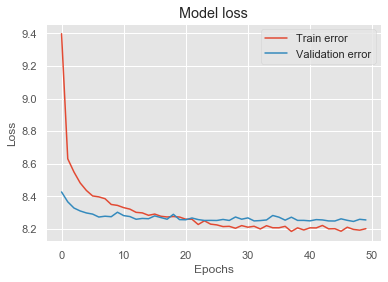

In [45]:
#Plotting the train and validation error:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train error', 'Validation error'], loc='upper right')
plt.show()

In [46]:
print("The RMSE of the FFNN model after 15th epoch is:", history.history["val_loss"][-1])

The RMSE of the FFNN model after 15th epoch is: 8.254007229006437


As seen in the training history of the FFNN the model learns through the first ~10 epochs and ends up with a validation error (which is performed on the test set) of 8.25. The learning process is also plotted above, and as we see there is no overfitting, since the validation error does not spike at any point. Dropout has the function of trying to prevent overfitting, which suggests a succesfull job in this regard. 

# Jens-------------

Spørg jensen:
- nedenstående tager laver en y_baseline, der er lige så lang som y_train. Men denne Y_baseline består af tallene fra "delivery difference" - dette skal vel være actual, når vi prøver at forudsige den faktiske delivery dato. 

In [ ]:
baseline_preds = delivered_orders['delivery_difference'].values
X_baseline = baseline_preds[:69774]
Y_baseline = baseline_preds[69774:]

baseline_errors = abs(Y_baseline - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'days')

In [ ]:


lr = LinearRegression()

lr.fit(X_train, y_train)

In [ ]:
predictions = lr.predict(X_test)

errors = abs(predictions - y_test)

print('Average baseline error: ', round(np.mean(errors), 2), 'days')

In [ ]:
mape = 100 * (errors/y_test)

accuracy = 100 - np.mean(mape)

print('Accuracy: ', round(accuracy, 2), '%')

In [ ]:
errors

In [ ]:
mape

# Jens-------------

# <font color='blue'>Part 3</font>: Prediction - Late delivery (yes or no)

This last analysis will seek to predict whether a delivery will be late or not. An online retailer platform like Olist can benefit from this analysis in several different ways: First, simply knowing which factors affect the delivery of orders is useful. Secondly, having this model deployed Olist would be able to warn sellers and customers when a order was predicted to be delivered late. 

his parameter setting means that the penalties for false predictions in the loss function will be weighted with inverse proportions to the frequencies of the classes. This can solve the problem you describe

This model will use logistic regression to perfrom the binary classification, where the the target variable $y$ is defined as: 1 if the order was delivered on time and 0 if it was late. T

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np

X = delivered_orders[['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']]
X = preprocessing.StandardScaler().fit_transform(X)

y = (delivered_orders.order_estimated_delivery_date > delivered_orders.order_delivered_customer_date).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
y.value_counts()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial', class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
name = ['quantity','order_price','freight_value','Distance','customer_lat','customer_lon','seller_lat', 'seller_lon']
coef = clf.coef_[0]

In [ ]:
list(zip(name,coef))

Interpretation of coefficients: 
- Orders with larger quantity are more likely to be delivered on time. 
- Orders with longer distance between seller and customer are less likely to be delivered on time.
- Orders with a high customer longitude coordinate are less likely to be delivered on time.
close to coast 

Features that could prove useful to this model, but has not yet been implemented:
- Weather forcast data
- Historical weather data
- Real distance between seller and customer (on roads)
- Seller track record (in terms of number of previously late deliveries. 
- Seller reviews (average)


- Previously late delivery

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
from pysal.viz.splot import mapping as maps

In [ ]:
delivered_orders['late'] = y

late_orders = delivered_orders[delivered_orders.late == 0]
df = late_orders[['customer_lat','customer_lon']]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.customer_lon, df.customer_lat))

orders = delivered_orders[delivered_orders.late == 1]
df1 = orders[['customer_lat','customer_lon']]
gdf1 = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.customer_lon, df1.customer_lat))

In [ ]:
delivered_orders.groupby(['customer_lat','customer_lon']).agg({'late':'sum', 'customer_lat':'count'})

In [ ]:
# define color dictionary
color_map = {1:"blue", 0:'red'}

In [ ]:
plt.rcParams['figure.figsize'] = [14, 6]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# restrict to South America.
ax1 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

ax2 = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')


colors_late = [color_map[x] for x in late_orders['late']]
gdf.plot(ax=ax1, color=colors_late, alpha=0.3, markersize=.1)

colors = [color_map[x] for x in orders['late']]
gdf1.plot(ax=ax2, color=colors, alpha=0.1, markersize=.1)
plt.show()


# <font color='blue'>Part 4</font>: Clustering - Warehouse locations

# Conclusion

- Operationelle vi går ind og optimere på for at sikre god oplevelse under og efter køb
- Der er et problem givet at 8% forsinkelser over alle ordre
- Går ind og kigger på hvad vi deskriptivt kan udlede af årsager til forsinkelserne, finder at: (1) det i høj grad er logistikudbyderens skyld at varerne er forsinket. (2) I mindre del at tilfældene er det seller som ikke har varen parat når logistikudbyderen skal 'tage over' 
- Derefter kigger vi på den estimerede tid til delivery, som informeres om efter køb. Her kan vi se at Olist systematisk informerer om en langt højere leveringstid end den tid de faktisk bruger på at levere. Vi finder frem til at vi godt kan lære af data, og at de kan give langt mere præcise leveringsestimater ved brug af de modeller, som er lavet. 
- Sidst går vi ind og ser om vi kan flagge potentielt forsinkede ordre inden det sker. Her påvises også at forskellige modeller kan fange et signal om, om en ordre leveres til tiden. --> fremtidigt arbejde hertil kan være at prediktere den faktiske forsinkelse, såfremt modellen prediktere at en vare bliver forsinket. 


- (1) --> bedre forhandling af logistikaftaler, fx som pålægning af bøder ved for sen levering fra 3. part. 
- (2) --> kan løses ved eksempelvis varelagre og på
- (3) --> de nye og bedre estimater af leverancer kan både bruges til at tiltrække kunder og til at fastholde kunder 
- (4) --> beredskabspakke som ved flagget ordre kan tages i brug for at ændre udfaldet, samtidig med at kunden bliver informeret hurtigst muligt, med et nyt og præcist estimat for levering --> bliver dette gjort korrekt, så forbedre det også den første KPI (antal forsinkelser). 




Estimated time of delivery
- her kan vi følge to KPI'er, hhv. Customer attention og Customer retention hvis vi kan begynde og reklamere med en hurtig og præcis leveringstid --> så dvs. vi giver dem information om deres leverance inden de køber frem for efter --> øget tilfredshed

Prediction late yes/no
- antallet af forsinkelser er en KPI i sig selv
- deskriptivt forarbejde, som viser hvad der oftest går galt 
- videre arbejde er derefter at kunne gå ind og sige: hvor meget er pakken forsinket
- --> så når vi får et signal om en forsinkelse så skal der SKE NOGET --> betydende faktorer kunne sige noget om.
- ideen er at vi på en eller anden måde skal kunne flagge en ordre og derefter have en toolbox som kan hjælpe med at undgå eller mindske denne forsinkelse, samt informere kunden så snart det opdaget og give dem en præcis prædiktion på en ny leveringsdag. 